In [ ]:
%pip install nbformat
%pip install plotly-resampler
%pip install pystan fbprophet

In [1]:

"""
SENTINEL - NeuralProphet Baseline Implementation
===============================================
Plataforma inteligente para monitoreo industrial y detección predictiva de fallas

Autor: Equipo SENTINEL
Fecha: Mayo 2025
Objetivo: Establecer baseline de forecasting con NeuralProphet para series temporales industriales
"""

# =============================================================================
# 1. PREPARACIÓN DEL ENTORNO Y DEPENDENCIAS
# =============================================================================

# Instalación de dependencias (ejecutar solo si es necesario)
"""
%pip install neuralprophet pandas numpy matplotlib plotly seaborn scikit-learn nbformat
"""

# Import de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta    
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# NeuralProphet y métricas
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


C:\Users\joaqu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:

# =============================================================================
# 1. CARGA Y PREPROCESAMIENTO DEL DATASET REAL (Water Treatment)
# =============================================================================

# Columnas del dataset
column_names = [
    'Q-E', 'ZN-E', 'PH-E', 'DBO-E', 'DQO-E', 'SS-E', 'SSV-E', 'SED-E', 'COND-E',
    'PH-P', 'DBO-P', 'SS-P', 'SSV-P', 'SED-P', 'COND-P',
    'PH-D', 'DBO-D', 'DQO-D', 'SS-D', 'SSV-D', 'SED-D', 'COND-D',
    'PH-S', 'DBO-S', 'DQO-S', 'SS-S', 'SSV-S', 'SED-S', 'COND-S',
    'RD-DBO-P', 'RD-SS-P', 'RD-SED-P',
    'RD-DBO-S', 'RD-DQO-S',
    'RD-DBO-G', 'RD-DQO-G', 'RD-SS-G', 'RD-SED-G'
]

print("Cargando datos reales desde 'water-treatment.data'...")
df_raw = pd.read_csv("water-treatment.data", names=column_names, na_values="?")

# Añadir columna temporal ficticia (requerida por NeuralProphet)
df_raw['ds'] = pd.date_range(start='2023-01-01', periods=len(df_raw), freq='D')

# Definir variable objetivo
df_raw['y'] = df_raw['DBO-S']  # Puedes cambiarla por otra variable relevante

# Eliminar columnas con más del 30% de datos faltantes
nan_ratio = df_raw.isnull().mean()
columns_to_drop = nan_ratio[nan_ratio > 0.3].index
print(f"Eliminando columnas con demasiados valores faltantes: {list(columns_to_drop)}")
df_raw.drop(columns=columns_to_drop, inplace=True)

# Rellenar los NaN restantes con la media de la columna
df_raw.fillna(df_raw.mean(numeric_only=True), inplace=True)

# Reiniciar índice (por claridad)
df_raw = df_raw.reset_index(drop=True)

# Verificación
print("=" * 50)
print("Información del dataset:")
print(df_raw.info())



Cargando datos reales desde 'water-treatment.data'...
Eliminando columnas con demasiados valores faltantes: []
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Q-E       527 non-null    float64       
 1   ZN-E      527 non-null    float64       
 2   PH-E      527 non-null    float64       
 3   DBO-E     527 non-null    float64       
 4   DQO-E     527 non-null    float64       
 5   SS-E      527 non-null    float64       
 6   SSV-E     527 non-null    float64       
 7   SED-E     527 non-null    float64       
 8   COND-E    527 non-null    int64         
 9   PH-P      527 non-null    float64       
 10  DBO-P     527 non-null    float64       
 11  SS-P      527 non-null    int64         
 12  SSV-P     527 non-null    float64       
 13  SED-P     527 non-null    float64       
 14  COND-P    527 non-

In [18]:
# Calcular correlaciones con la variable objetivo 'y'
print("\n Top correlaciones con la variable objetivo (DBO-S):")
correlation_matrix = df_raw.corr(numeric_only=True)
top_regressors = correlation_matrix['y'].drop('y').sort_values(key=abs, ascending=False)
print(top_regressors)



 Top correlaciones con la variable objetivo (DBO-S):
DBO-S       1.000000
SS-S        0.849064
RD-SED-G   -0.705409
RD-SS-G    -0.673064
SED-S       0.661407
DQO-S       0.618071
RD-DBO-G   -0.535435
RD-DBO-S   -0.493087
RD-DQO-G   -0.320188
RD-DQO-S   -0.229005
DQO-D       0.202317
DBO-D       0.178704
month      -0.161473
PH-S       -0.157325
DBO-E       0.139044
SS-D        0.117917
RD-DBO-P   -0.109848
DQO-E       0.105890
SED-D       0.089191
PH-D       -0.080425
DBO-P       0.073517
SED-P       0.056150
RD-SS-P    -0.041395
COND-S      0.035813
SED-E       0.034692
PH-E       -0.031629
COND-D      0.028867
RD-SED-P   -0.019923
PH-P       -0.019838
COND-E      0.015810
SS-E        0.015121
ZN-E       -0.014646
SSV-D      -0.013906
SSV-E       0.011941
SSV-S       0.011459
COND-P      0.008828
SS-P        0.005643
SSV-P       0.003540
Q-E         0.001140
Name: y, dtype: float64


key_regressors = ['SS-S', 'SED-S', 'DQO-S', 'RD-SS-G', 'RD-SED-G', 'RD-DBO-G', 'RD-DBO-S']


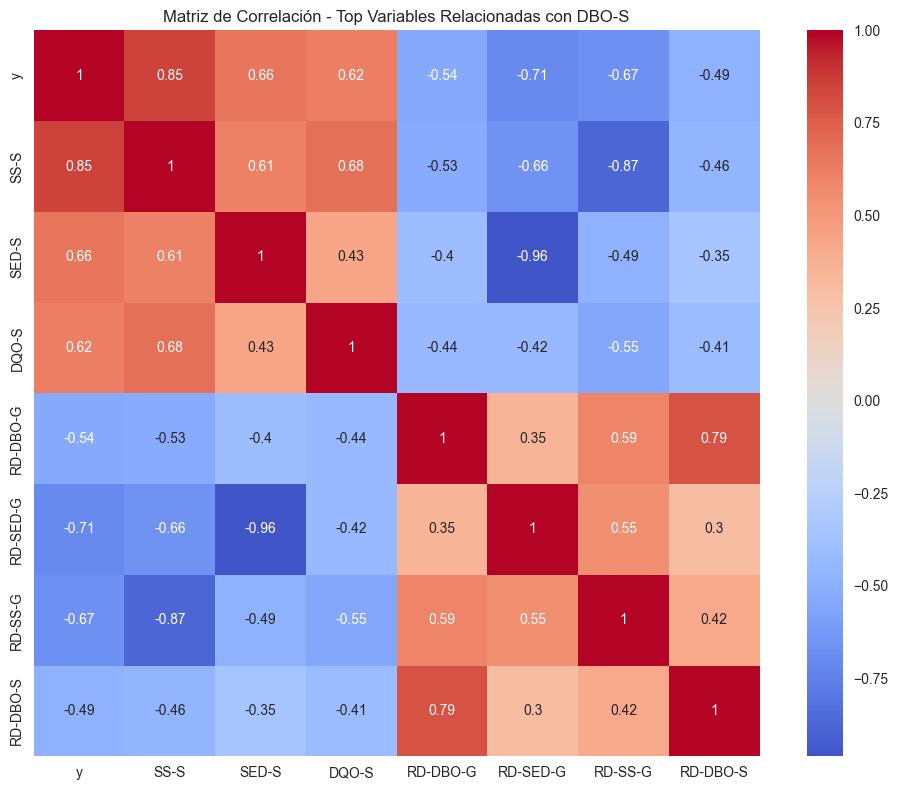

Correlaciones con DBO-S:
  • SS-S: 0.849
  • RD-SED-G: -0.705
  • RD-SS-G: -0.673
  • SED-S: 0.661
  • DQO-S: 0.618
  • RD-DBO-G: -0.535
  • RD-DBO-S: -0.493


In [3]:
# =============================================================================
# 3. ANÁLISIS EXPLORATORIO DE DATOS (EDA) - Dataset Real
# =============================================================================

def plot_eda_analysis_real(df):
    """
    Genera análisis exploratorio visual para el dataset real (Water Treatment).
    
    Incluye:
    - Serie temporal de DBO-S
    - Histograma de DBO-S
    - Correlación con otras variables
    - Estacionalidad diaria (por día del año)
    - Evolución de variables exógenas
    - Matriz de correlación extendida con top variables
    """
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            'Serie Temporal - DBO-S (Variable Objetivo)',
            'Distribución de DBO-S',
            'DBO-S vs SS-S',
            'Media por Mes',
            'Evolución de Variables Exógenas',
            'Matriz de Correlación'
        ],
        specs=[[{}, {}],
               [{}, {}],
               [{"secondary_y": True}, {}]]
    )

    # 1. Serie temporal de DBO-S
    fig.add_trace(
        go.Scatter(x=df['ds'], y=df['y'], name='DBO-S', line=dict(color='blue')),
        row=1, col=1
    )

    # 2. Histograma de DBO-S
    fig.add_trace(
        go.Histogram(x=df['y'], nbinsx=40, marker_color='lightblue'),
        row=1, col=2
    )

    # 3. Dispersión: DBO-S vs SS-S (alta correlación)
    fig.add_trace(
        go.Scatter(
            x=df['SS-S'], y=df['y'],
            mode='markers',
            marker=dict(size=4, color='red', opacity=0.6),
            name='DBO-S vs SS-S'
        ),
        row=2, col=1
    )

    # 4. Comportamiento promedio mensual
    df['month'] = df['ds'].dt.month
    monthly_avg = df.groupby('month')['y'].mean()
    fig.add_trace(
        go.Bar(x=monthly_avg.index, y=monthly_avg.values, name='Promedio Mensual'),
        row=2, col=2
    )

    # 5. Variables exógenas (muestreo)
    sample = df.iloc[::10]
    fig.add_trace(
        go.Scatter(x=sample['ds'], y=sample['DQO-S'], name='DQO-S', line=dict(color='orange')),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=sample['ds'], y=sample['SS-S'], name='SS-S', line=dict(color='purple'), yaxis='y2'),
        row=3, col=1, secondary_y=True
    )

    # Layout y etiquetas
    fig.update_layout(
        height=1200,
        title="Análisis Exploratorio - Dataset Planta de Tratamiento (SENTINEL)",
        showlegend=True
    )
    fig.update_yaxes(title_text="DBO-S (mg/L)", row=1, col=1)
    fig.update_yaxes(title_text="Frecuencia", row=1, col=2)
    fig.update_yaxes(title_text="DBO-S", row=2, col=1)
    fig.update_yaxes(title_text="Promedio mensual", row=2, col=2)
    fig.update_yaxes(title_text="DQO-S", row=3, col=1)
    fig.update_yaxes(title_text="SS-S", row=3, col=1, secondary_y=True)
    
    fig.show()

    # 6. Matriz de correlación con variables más relevantes
    top_corr_vars = ['y', 'SS-S', 'SED-S', 'DQO-S', 'RD-DBO-G', 'RD-SED-G', 'RD-SS-G', 'RD-DBO-S']
    corr_matrix = df[top_corr_vars].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, center=0)
    plt.title("Matriz de Correlación - Top Variables Relacionadas con DBO-S")
    plt.tight_layout()
    plt.show()

    print("Correlaciones con DBO-S:")
    target_corr = corr_matrix['y'].drop('y').sort_values(key=abs, ascending=False)
    for var, corr in target_corr.items():
        print(f"  • {var}: {corr:.3f}")

# Ejecutar EDA
plot_eda_analysis_real(df_raw)


In [20]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS PARA NEURALPROPHET (Water Treatment)
# =============================================================================

def prepare_data_for_neuralprophet(df, test_size=0.2):
    """
    Prepara los datos reales del dataset de tratamiento de aguas para entrenamiento con NeuralProphet.
    
    Parámetros:
    - df: DataFrame con los datos limpios y preprocesados
    - test_size: proporción de registros a reservar para prueba
    
    Retorna:
    - df_train, df_test: subconjuntos de entrenamiento y prueba
    """
    
    # Ordenar por fecha para evitar fuga de información temporal
    df = df.sort_values('ds').reset_index(drop=True)
    
    # Punto de corte para división
    split_point = int(len(df) * (1 - test_size))
    
    # División en conjunto de entrenamiento y prueba
    df_train = df.iloc[:split_point].copy() # Asegurarse de que el entrenamiento no incluya datos futuros
    df_test = df.iloc[split_point:].copy()
    
    print("División de datos realizada:")
    
    print(f"  • Entrenamiento: {len(df_train)} registros ({df_train['ds'].min().date()} a {df_train['ds'].max().date()})") 
    print(f"  • Prueba: {len(df_test)} registros ({df_test['ds'].min().date()} a {df_test['ds'].max().date()})")
    
    return df_train, df_test

# Aplicar división con el dataset real
df_train, df_test = prepare_data_for_neuralprophet(df_raw, test_size=0.2)

# Selección de variables exógenas relevantes según correlación
# Estas variables se utilizarán como regresores en NeuralProphet
# Basado en el análisis previo, seleccionamos las más correlacionadas con 'y'
key_regressors = [
    'DQO-D', 'DBO-D', 'DBO-E', 'DQO-E', 'SS-D', 'PH-D'
    # Puedes agregar 'RD-DBO-G', 'RD-SS-G' si estás seguro que no usan outputs futuros
]

print("\nVariables seleccionadas para el modelo:")
print("  • Variable objetivo: y (DBO-S)")
print(f"  • Variables exógenas: {key_regressors}")

División de datos realizada:
  • Entrenamiento: 421 registros (2023-01-01 a 2024-02-25)
  • Prueba: 106 registros (2024-02-26 a 2024-06-10)

Variables seleccionadas para el modelo:
  • Variable objetivo: y (DBO-S)
  • Variables exógenas: ['DQO-D', 'DBO-D', 'DBO-E', 'DQO-E', 'SS-D', 'PH-D']


In [5]:
print("Shape de df_train:", df_train.shape)
print(df_train.head())

Shape de df_train: (421, 41)
       Q-E  ZN-E  PH-E       DBO-E  DQO-E   SS-E  SSV-E  SED-E  COND-E  PH-P       DBO-P  SS-P  SSV-P  SED-P  COND-P  PH-D       DBO-D  DQO-D  SS-D  SSV-D  SED-D  COND-D  PH-S      DBO-S  DQO-S  SS-S  SSV-S  SED-S  COND-S   RD-DBO-P  RD-SS-P  RD-SED-P   RD-DBO-S  RD-DQO-S   RD-DBO-G  RD-DQO-G  RD-SS-G  RD-SED-G         ds          y  month
0  44101.0   1.5   7.8  188.714286  407.0  166.0   66.3    4.5    2110   7.9  206.207392   228   70.2    5.5    2120   7.9  122.348697  280.0  94.0   72.3    0.3    2010   7.3  19.988095   84.0  21.0   81.0   0.02  2000.0  39.085806     58.8      95.5  83.448049      70.0  89.013646      79.4     87.3      99.6 2023-01-01  19.988095      1
1  39024.0   3.0   7.7  188.714286  443.0  214.0   69.2    6.5    2660   7.7  206.207392   244   75.4    7.7    2570   7.6  122.348697  474.0  96.0   79.2    0.4    2700   7.5  19.988095   91.0  17.0   94.1   0.00  2590.0  39.085806     60.7      94.8  83.448049      80.8  89.013646    

In [32]:
# =============================================================================
# 5. ENTRENAMIENTO DE NEURALPROPHET
# =============================================================================

from neuralprophet import NeuralProphet

def create_and_train_neuralprophet_model(df_train, regressors=None, val_ratio=0.2):
    """
    Crea y entrena un modelo NeuralProphet ajustado para monitoreo industrial (SENTINEL).

    Parámetros:
    - df_train: DataFrame completo de entrenamiento (con 'ds', 'y' y posibles regresores).
    - regressors: lista de variables exógenas (lagged_regressors).
    - val_ratio: proporción del conjunto de entrenamiento que se usará como validación.

    Retorna:
    - model: modelo entrenado listo para inferencia.
    - metrics: métricas del entrenamiento por época.
    """

    # Separar subconjuntos para entrenamiento y validación
    split_idx = int(len(df_train) * (1 - val_ratio))
    df_train_sub = df_train.iloc[:split_idx].copy()
    df_val_sub = df_train.iloc[split_idx:].copy()

    print(f"Conjunto de entrenamiento: {len(df_train_sub)} registros")
    print(f"Conjunto de validación: {len(df_val_sub)} registros")

    # Configuración del modelo
    model = NeuralProphet(
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    n_forecasts=1,
    n_lags=5,
    learning_rate=0.005,
    epochs=800,
    batch_size=32,
    normalize='minmax',
    loss_func='Huber',
    newer_samples_weight=1.5,
    seasonality_mode='additive',

    )

    # Incluir regresores si están definidos
    if regressors:
        for reg in regressors:
            print(f"Incluyendo variable exógena: {reg}")
            model.add_lagged_regressor(reg, n_lags=5)

    # Filtrar columnas necesarias
    df_model_train = df_train_sub[['ds', 'y'] + (regressors or [])]
    df_model_val = df_val_sub[['ds', 'y'] + (regressors or [])]

    print("Iniciando entrenamiento con validación...")
    metrics = model.fit(df_model_train, freq='D', validation_df=df_model_val)
    print("Entrenamiento completado.")

    return model, metrics


model, metrics = create_and_train_neuralprophet_model(df_train, regressors=key_regressors)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - C:\Users\joaqu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.702% of the data.
WARNING - (py.warnings._showwarnmsg) - C:\Users\joaqu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - C:\Users\joaqu\AppData\Local\Packages\PythonSof

Conjunto de entrenamiento: 336 registros
Conjunto de validación: 85 registros
Incluyendo variable exógena: DQO-D
Incluyendo variable exógena: DBO-D
Incluyendo variable exógena: DBO-E
Incluyendo variable exógena: DQO-E
Incluyendo variable exógena: SS-D
Incluyendo variable exógena: PH-D
Iniciando entrenamiento con validación...
Training: |          | 0/? [01:50<?, ?it/s, v_num=31, MAE_val=5.130, RMSE_val=6.470, Loss_val=0.000693, RegLoss_val=0.000, train_loss=0.00301, reg_loss=0.000, MAE=7.130, RMSE=13.60, Loss=0.00291, RegLoss=0.000]
Entrenamiento completado.


WARNING - (py.warnings._showwarnmsg) - C:\Users\joaqu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.057% of the data.
WARNING - (py.warnings._showwarnmsg) - C:\Users\joaqu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - C:\Users\joaqu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neuralprophet\df_utils.py:1152

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.99it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



=== Evaluación del Modelo (Conjunto de Prueba) ===
MAE : 8.140
RMSE: 13.848
R²  : 0.219


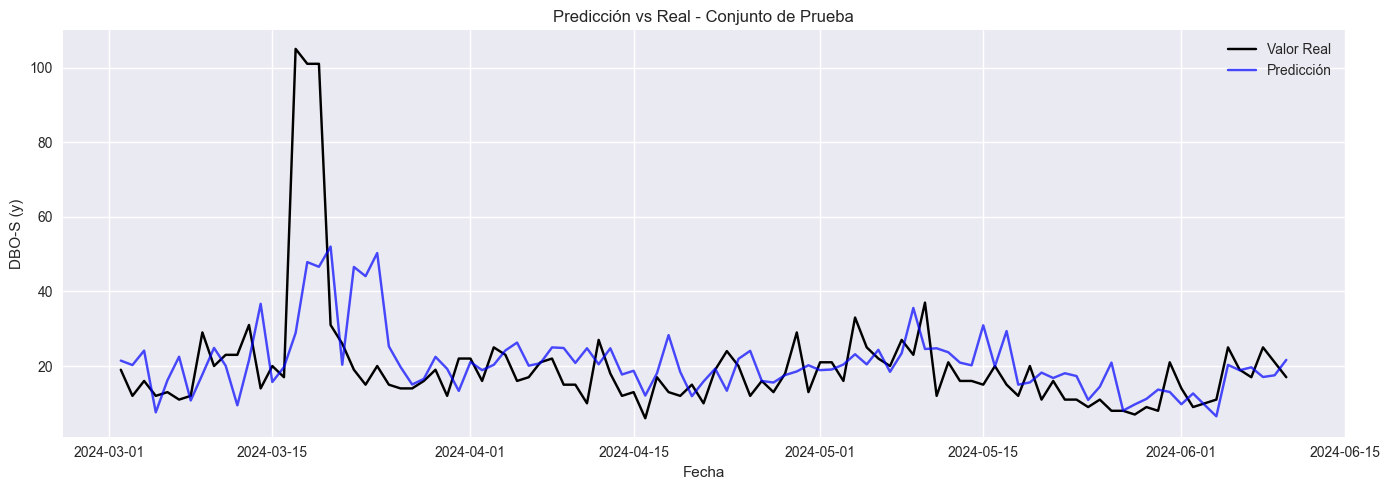

In [33]:
# =============================================================================
# 6. EVALUACIÓN DEL MODELO CON EL CONJUNTO DE PRUEBA
# =============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, df_test, regressors=None):
    """
    Evalúa el modelo entrenado sobre el conjunto de prueba.

    Parámetros:
    - model: modelo NeuralProphet ya entrenado.
    - df_test: DataFrame con datos de prueba (debe contener 'ds', 'y' y los regresores).
    - regressors: lista de regresores usados durante el entrenamiento.

    Retorna:
    - None (muestra métricas y gráficos)
    """

    # Preparar subconjunto con columnas requeridas
    df_model_test = df_test[['ds', 'y'] + (regressors or [])].copy()

    # Realizar predicciones
    forecast = model.predict(df_model_test)

    # Extraer valores reales y predichos
    y_true = df_model_test['y'].values
    y_pred = forecast['yhat1'].values

    # Filtrar NaN
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Calcular métricas
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print("=== Evaluación del Modelo (Conjunto de Prueba) ===")
    print(f"MAE : {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")

    # Gráfico real vs predicho
    plt.figure(figsize=(14, 5))
    ds = df_model_test['ds'].values
    ds = ds[mask]

    plt.plot(ds, y_true, label="Valor Real", color='black')
    plt.plot(ds, y_pred, label="Predicción", color='blue', alpha=0.7)
    plt.title("Predicción vs Real - Conjunto de Prueba")
    plt.xlabel("Fecha")
    plt.ylabel("DBO-S (y)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejecutar evaluación
evaluate_model_on_test_set(model, df_test, regressors=key_regressors)


In [ ]:
from neuralprophet import NeuralProphet
import pandas as pd

# Combinaciones de regresores a comparar
combinations = [
    ['DQO-D', 'DBO-D'],
    ['DBO-D', 'DQO-D', 'DBO-E', 'DQO-E'],
    ['DQO-D', 'DBO-D', 'PH-D', 'DBO-E', 'DQO-E', 'SS-D']
]

results = []

for regressors in combinations:
    print(f"\nEntrenando modelo con: {regressors}")
    model = NeuralProphet(
        growth='linear',
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False,
        n_forecasts=1,
        n_lags='auto',
        learning_rate=0.01,
        epochs=500,
        batch_size=32,
        normalize='standardize',
        loss_func='Huber',
        newer_samples_weight=1.2,
        seasonality_mode='additive'
    )
    
for reg in regressors:
    model.add_lagged_regressor(reg, n_lags=7)
    
    # División entrenamiento/validación
    split_idx = int(len(df_train) * 0.8)
    df_train_sub = df_train.iloc[:split_idx].copy()
    df_val_sub = df_train.iloc[split_idx:].copy()
    
    df_model_train = df_train_sub[['ds', 'y'] + regressors]
    df_model_val = df_val_sub[['ds', 'y'] + regressors]

    
    
    metrics = model.fit(df_model_train, freq='D', validation_df=df_model_val)
    last = metrics.iloc[-1]
    
    results.append({
        'Regresores': ', '.join(regressors),
        'MAE_val': last['MAE_val'],
        'RMSE_val': last['RMSE_val'],
        'Loss_val': last['Loss_val']
    })

# Mostrar resumen ordenado por MAE
resultados_df = pd.DataFrame(results).sort_values(by='MAE_val')
print(resultados_df)

In [ ]:
# =============================================================================
# 7. VISUALIZACIÓN DE RESULTADOS
# =============================================================================

def plot_comprehensive_results(df_train, df_test, forecast_train, forecast_test, model):
    """
    Genera visualizaciones completas de los resultados del modelo
    """
    
    # === GRÁFICO PRINCIPAL: PREDICCIONES VS REALIDAD ===
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            ' Predicciones vs Realidad - Serie Completa',
            ' Zoom: Últimos 30 días de Prueba',
            ' Residuales - Conjunto de Entrenamiento',
            ' Residuales - Conjunto de Prueba',
            ' Componentes del Modelo',
            ' Distribución de Errores'
        ],
        specs=[[{"colspan": 2}, None],
               [{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 1. Serie temporal completa
    fig.add_trace(
        go.Scatter(x=df_train['ds'], y=df_train['y'], 
                  name='Datos Reales (Train)', line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=df_test['y'], 
                  name='Datos Reales (Test)', line=dict(color='darkblue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=forecast_train['ds'], y=forecast_train['yhat1'], 
                  name='Predicciones (Train)', line=dict(color='red', width=1)),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat1'], 
                  name='Predicciones (Test)', line=dict(color='orange', width=2)),
        row=1, col=1
    )
    
    # Intervalos de confianza
    if 'yhat1_lower' in forecast_test.columns and 'yhat1_upper' in forecast_test.columns:
        fig.add_trace(
            go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat1_upper'], 
                      fill=None, mode='lines', line_color='rgba(0,0,0,0)', 
                      showlegend=False),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat1_lower'], 
                      fill='tonexty', mode='lines', line_color='rgba(0,0,0,0)', 
                      name='Intervalo Confianza', fillcolor='rgba(255,165,0,0.2)'),
            row=1, col=1
        )
    
    # 2. Zoom a últimos 30 días de prueba
    last_30_days = df_test.tail(720)  # 30 días * 24 horas
    forecast_30_days = forecast_test.tail(720)
    
    fig.add_trace(
        go.Scatter(x=last_30_days['ds'], y=last_30_days['y'], 
                  name='Real (30d)', line=dict(color='blue', width=3)),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=forecast_30_days['ds'], y=forecast_30_days['yhat1'], 
                  name='Predicción (30d)', line=dict(color='red', width=2)),
        row=2, col=1
    )
    
    # 3. Residuales de entrenamiento
    train_residuals = df_train['y'].values - forecast_train['yhat1'].values
    fig.add_trace(
        go.Scatter(x=df_train['ds'], y=train_residuals, 
                  mode='markers', name='Residuales Train', 
                  marker=dict(color='green', size=2, opacity=0.6)),
        row=2, col=2
    )
    fig.add_hline(y=0, line_dash="dash", line_color="black", row=2, col=2)
    
    # 4. Residuales de prueba
    test_residuals = df_test['y'].values - forecast_test['yhat1'].values
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=test_residuals, 
                  mode='markers', name='Residuales Test', 
                  marker=dict(color='red', size=3, opacity=0.7)),
        row=3, col=1
    )
    fig.add_hline(y=0, line_dash="dash", line_color="black", row=3, col=1)
    
    # 5. Distribución de errores
    fig.add_trace(
        go.Histogram(x=test_residuals, name='Dist. Errores', 
                    nbinsx=30, marker_color='lightcoral'),
        row=3, col=2
    )
    
    # Actualizar layout
    fig.update_layout(
        height=1200,
        title_text=" SENTINEL - Resultados del Modelo NeuralProphet",
        showlegend=True
    )
    
    # Etiquetas de ejes
    fig.update_yaxes(title_text="Presión (PSI)", row=1, col=1)
    fig.update_yaxes(title_text="Presión (PSI)", row=2, col=1)
    fig.update_yaxes(title_text="Residuales", row=2, col=2)
    fig.update_yaxes(title_text="Residuales", row=3, col=1)
    fig.update_yaxes(title_text="Frecuencia", row=3, col=2)
    
    return fig

# Generar visualización completa
results_fig = plot_comprehensive_results(df_train_eval, df_test_eval, forecast_train, forecast_test, model)

results_fig.show()

# === COMPONENTES DEL MODELO ===
print(" Analizando componentes del modelo...")

# Plotear componentes del modelo (solo datos de entrenamiento)
fig_components = model.plot_components(forecast_train)
fig_components.show()


In [ ]:
# =============================================================================
# 8. ANÁLISIS DE IMPORTANCIA DE VARIABLES
# =============================================================================

def analyze_feature_importance(model, regressors):
    """
    Analiza la importancia de las variables en el modelo
    """
    print("🔍 Analizando importancia de variables...\n")

    # Obtener parámetros del modelo
    params = model.model.named_parameters()

    print("\n📊 Variables incluidas en el modelo:")
    print(f"  • Variable objetivo: y (presión)")

    # Lags de la variable objetivo
    if hasattr(model.config_lagged_regressors, "y"):
        print(f"  • Lags autorregresivos: {model.config_lagged_regressors.y.n_lags}")
    else:
        print("  • Lags autorregresivos: 0")

    # Lags de los regresores
    for regressor in regressors:
        reg = getattr(model.config_lagged_regressors, regressor, None)
        n_lags = reg.n_lags if reg is not None else 0
        print(f"  • {regressor}: {n_lags} lags")

    return params

# Analizar importancia
importance_analysis = analyze_feature_importance(model, key_regressors)

# === IMPORTANCIA DE VARIABLES POR ABLACIÓN ===
def variable_importance_by_ablation(df_train, df_test, base_regressors):
    print("\n Estimando importancia de variables por ablation (quitando una a una):")
    results = []
    # Modelo base (con todas las variables)
    base_model, _ = create_and_train_neuralprophet_model(df_train, regressors=base_regressors)
    _, _, _, _, base_test_metrics, _, _ = generate_predictions_and_evaluate(base_model, df_train, df_test, base_regressors)
    base_mape = base_test_metrics['MAPE']
    print(f"  • MAPE base (todas las variables): {base_mape:.2f}%")
    # Probar quitando cada variable
    for reg in base_regressors:
        reduced = [r for r in base_regressors if r != reg]
        model, _ = create_and_train_neuralprophet_model(df_train, regressors=reduced)
        _, _, _, _, test_metrics, _, _ = generate_predictions_and_evaluate(model, df_train, df_test, reduced)
        mape = test_metrics['MAPE']
        delta = mape - base_mape
        print(f"  • Sin '{reg}': MAPE={mape:.2f}%  (ΔMAPE={delta:+.2f}%)")
        results.append({'regressor': reg, 'mape_without': mape, 'delta_mape': delta})
    return results

# Ejecutar análisis de importancia
ablation_results = variable_importance_by_ablation(df_train, df_test, key_regressors)


In [ ]:
# =============================================================================
# 9. PREDICCIONES FUTURAS
# =============================================================================

def generate_future_predictions(model, df_full, periods=168, regressors=None):
    """
    Genera predicciones futuras (168 horas = 1 semana)
    
    Parámetros:
    - model: modelo entrenado
    - df_full: datos completos
    - periods: períodos a predecir
    - regressors: variables exógenas
    
    Retorna:
    - DataFrame con predicciones futuras
    """
    
    print(f"🔮 Generando predicciones futuras para {periods} horas ({periods//24} días)...")

    # Crear fechas futuras
    last_date = df_full['ds'].max()
    future_dates = pd.date_range(
        start=last_date + timedelta(hours=1),
        periods=periods,
        freq='H'
    )

    # Crear DataFrame futuro
    df_future = pd.DataFrame({'ds': future_dates})

    # Proyectar variables exógenas
    if regressors:
        print("  Proyectando variables exógenas usando tendencias históricas...")
        for regressor in regressors:
            last_values = df_full[regressor].tail(24).values
            mean_val = np.mean(last_values)
            std_val = np.std(last_values)
            if regressor == 'temperature':
                future_vals = mean_val + 3 * np.sin(2 * np.pi * np.arange(periods) / 24)
                future_vals += np.random.normal(0, std_val * 0.5, periods)
            elif regressor == 'flow':
                future_vals = np.full(periods, mean_val) + np.random.normal(0, std_val * 0.3, periods)
            elif regressor == 'vibration':
                trend = np.linspace(0, 0.5, periods)
                future_vals = mean_val + trend + np.random.normal(0, std_val * 0.2, periods)
            else:
                future_vals = np.full(periods, mean_val) + np.random.normal(0, std_val * 0.3, periods)
            df_future[regressor] = future_vals

        # Rellenar posibles NaN
        for reg in regressors:
            if reg in df_future.columns:
                df_future[reg] = df_future[reg].interpolate(limit_direction='both')
                df_future[reg] = df_future[reg].fillna(method='ffill').fillna(method='bfill')

    # Predecir SOLO el futuro
    future_forecast = model.predict(df_future)

    return future_forecast, df_future

# Generar predicciones futuras
future_predictions, df_future = generate_future_predictions(
    model, df_raw, periods=168, regressors=key_regressors
)

print(" Predicciones futuras generadas!")
print(f"Período futuro: {future_predictions['ds'].min()} a {future_predictions['ds'].max()}")

# Visualizar predicciones futuras
fig_future = go.Figure()

# Datos históricos (últimos 30 días)
recent_data = df_raw.tail(720)
fig_future.add_trace(
    go.Scatter(x=recent_data['ds'], y=recent_data['y'], 
              name='Datos Históricos', line=dict(color='blue', width=2))
)

# Predicciones futuras
fig_future.add_trace(
    go.Scatter(x=future_predictions['ds'], y=future_predictions['yhat1'], 
              name='Predicciones Futuras', line=dict(color='red', width=3))
)
# Intervalos de confianza futuros (si están disponibles)
if 'yhat1_lower' in future_predictions.columns and 'yhat1_upper' in future_predictions.columns:
    fig_future.add_trace(
        go.Scatter(x=future_predictions['ds'], y=future_predictions['yhat1_upper'], 
                  fill=None, mode='lines', line_color='rgba(0,0,0,0)', 
                  showlegend=False)
    )
    fig_future.add_trace(
        go.Scatter(x=future_predictions['ds'], y=future_predictions['yhat1_lower'], 
                  fill='tonexty', mode='lines', line_color='rgba(0,0,0,0)', 
                  name='Intervalo de Confianza', fillcolor='rgba(255,0,0,0.2)')
    )

# Línea divisoria
last_historical_date = df_raw['ds'].max()
fig_future.add_vline(x=last_historical_date, line_dash="dash", 
                    line_color="green", line_width=2,
                    annotation_text="Inicio Predicciones")

fig_future.update_layout(
    title=" SENTINEL - Predicciones Futuras (1 Semana)",
    xaxis_title="Fecha",
    yaxis_title="Presión (PSI)",
    height=600,
    showlegend=True
)

fig_future.show()


In [ ]:
# =============================================================================
# 10. DETECCIÓN DE ANOMALÍAS Y ALERTAS
# =============================================================================

def detect_anomalies_and_alerts(df_test, forecast_test, threshold_factor=2.5):
    """
    Detecta anomalías y genera alertas basadas en los residuales del modelo
    
    Parámetros:
    - df_test: datos de prueba reales
    - forecast_test: predicciones de prueba
    - threshold_factor: factor para definir umbral de anomalía
    
    Retorna:
    - DataFrame con anomalías detectadas
    """
    
    print("🚨 Detectando anomalías y generando alertas...")
    
    # Calcular residuales
    residuals = df_test['y'].values - forecast_test['yhat1'].values
    
    # Calcular umbrales estadísticos
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    
    upper_threshold = residual_mean + threshold_factor * residual_std
    lower_threshold = residual_mean - threshold_factor * residual_std
    
    # Detectar anomalías
    anomalies = []
    
    for i, (_, row) in enumerate(df_test.iterrows()):
        residual = residuals[i]
        prediction = forecast_test.iloc[i]['yhat1']
        actual = row['y']
        
        if residual > upper_threshold or residual < lower_threshold:
            severity = "CRÍTICA" if abs(residual) > threshold_factor * 1.5 * residual_std else "ALTA"
            
            anomaly = {
                'timestamp': row['ds'],
                'valor_real': actual,
                'valor_predicho': prediction,
                'residual': residual,
                'severidad': severity,
                'tipo': 'ALTA' if residual > upper_threshold else 'BAJA',
                'descripcion': f"Presión {'superior' if residual > 0 else 'inferior'} a lo esperado"
            }
            anomalies.append(anomaly)
    
    df_anomalies = pd.DataFrame(anomalies)
    
    print(f" Resultados de detección de anomalías:")
    print(f"  • Total de anomalías detectadas: {len(df_anomalies)}")
    print(f"  • Umbral superior: +{upper_threshold:.2f}")
    print(f"  • Umbral inferior: {lower_threshold:.2f}")
    
    if len(df_anomalies) > 0:
        print(f"\n  Distribución por severidad:")
        severity_counts = df_anomalies['severidad'].value_counts()
        for severity, count in severity_counts.items():
            print(f"    • {severity}: {count} eventos")
        
        print(f"\n Primeras 5 anomalías detectadas:")
        for _, anomaly in df_anomalies.head().iterrows():
            print(f"    • {anomaly['timestamp']}: {anomaly['descripcion']} "
                  f"(Real: {anomaly['valor_real']:.2f}, Pred: {anomaly['valor_predicho']:.2f})")
    
    return df_anomalies, upper_threshold, lower_threshold

# Detectar anomalías
df_anomalies, upper_thresh, lower_thresh = detect_anomalies_and_alerts(
    df_test_eval, forecast_test, threshold_factor=2.5
)

# Visualizar anomalías
def plot_anomalies(df_test, forecast_test, df_anomalies, upper_thresh, lower_thresh):
    """Visualizar anomalías detectadas"""
    
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=['Serie Temporal con Anomalías Detectadas', 
                       ' Residuales y Umbrales de Detección'],
        vertical_spacing=0.1
    )
    
    # Serie temporal con anomalías
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=df_test['y'], 
                  name='Valores Reales', line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat1'], 
                  name='Predicciones', line=dict(color='red', dash='dot')),
        row=1, col=1
    )
    
    # Marcar anomalías
    if len(df_anomalies) > 0:
        anomalies_critical = df_anomalies[df_anomalies['severidad'] == 'CRÍTICA']
        anomalies_high = df_anomalies[df_anomalies['severidad'] == 'ALTA']
        
        if len(anomalies_critical) > 0:
            fig.add_trace(
                go.Scatter(x=anomalies_critical['timestamp'], 
                          y=anomalies_critical['valor_real'],
                          mode='markers', name='Anomalías CRÍTICAS',
                          marker=dict(color='red', size=12, symbol='x')),
                row=1, col=1
            )
        
        if len(anomalies_high) > 0:
            fig.add_trace(
                go.Scatter(x=anomalies_high['timestamp'], 
                          y=anomalies_high['valor_real'],
                          mode='markers', name='Anomalías ALTAS',
                          marker=dict(color='orange', size=8, symbol='triangle-up')),
                row=1, col=1
            )
    
    # Residuales con umbrales
    residuals = df_test['y'].values - forecast_test['yhat1'].values
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=residuals, 
                  mode='markers', name='Residuales',
                  marker=dict(color='gray', size=4, opacity=0.6)),
        row=2, col=1
    )
    
    # Umbrales
    fig.add_hline(y=upper_thresh, line_dash="dash", line_color="red", 
                 annotation_text="Umbral Superior", row=2, col=1)
    fig.add_hline(y=lower_thresh, line_dash="dash", line_color="red", 
                 annotation_text="Umbral Inferior", row=2, col=1)
    fig.add_hline(y=0, line_color="black", line_width=1, row=2, col=1)
    
    fig.update_layout(
        height=800,
        title_text=" SENTINEL - Detección de Anomalías",
        showlegend=True
    )
    
    fig.update_yaxes(title_text="Presión (PSI)", row=1, col=1)
    fig.update_yaxes(title_text="Residuales", row=2, col=1)
    fig.update_xaxes(title_text="Fecha", row=2, col=1)
    
    return fig

if len(df_anomalies) > 0:
    anomalies_fig = plot_anomalies(df_test, forecast_test, df_anomalies, upper_thresh, lower_thresh)
    anomalies_fig.show()


In [ ]:
# =============================================================================
# 11. RESUMEN EJECUTIVO Y MÉTRICAS FINALES
# =============================================================================

def generate_executive_summary(train_metrics, test_metrics, df_anomalies, df_raw):
    """
    Genera un resumen ejecutivo de los resultados del modelo SENTINEL
    """
    
    print("\n" + "="*80)
    print(" SENTINEL - RESUMEN EJECUTIVO DEL MODELO NEURALPROPHET")
    print("="*80)
    
    print(f"\n INFORMACIÓN DEL DATASET:")
    print(f"    • Total de registros: {len(df_raw):,}")
    print(f"    • Período analizado: {df_raw['ds'].min()} a {df_raw['ds'].max()}")
    print(f"    • Frecuencia: Horaria")
    print(f"    • Variables predictoras: Presión (objetivo), Temperatura, Flujo, Vibración")
    
    print(f"\n DESEMPEÑO DEL MODELO:")
    print(f"     ENTRENAMIENTO:")
    print(f"        • MAE (Error Absoluto Medio): {train_metrics['MAE']:.4f} PSI")
    print(f"        • RMSE (Error Cuadrático Medio): {train_metrics['RMSE']:.4f} PSI")
    print(f"        • MAPE (Error Porcentual): {train_metrics['MAPE']:.2f}%")
    print(f"        • R² (Coeficiente Determinación): {train_metrics['R²']:.4f}")
    
    print(f"     PRUEBA:")
    print(f"        • MAE (Error Absoluto Medio): {test_metrics['MAE']:.4f} PSI")
    print(f"        • RMSE (Error Cuadrático Medio): {test_metrics['RMSE']:.4f} PSI")
    print(f"        • MAPE (Error Porcentual): {test_metrics['MAPE']:.2f}%")
    print(f"        • R² (Coeficiente Determinación): {test_metrics['R²']:.4f}")
    
    # Evaluación de calidad
    if test_metrics['MAPE'] < 5:
        quality = "EXCELENTE "
    elif test_metrics['MAPE'] < 10:
        quality = "BUENA "
    elif test_metrics['MAPE'] < 15:
        quality = "ACEPTABLE "
    else:
        quality = "NECESITA MEJORA "
    
    print(f"     CALIDAD DEL MODELO: {quality}")
    
    print(f"\n DETECCIÓN DE ANOMALÍAS:")
    if len(df_anomalies) > 0:
        print(f"    • Total de anomalías detectadas: {len(df_anomalies)}")
        severity_counts = df_anomalies['severidad'].value_counts()
        for severity, count in severity_counts.items():
            print(f"    • {severity}: {count} eventos")
        
        # Calcular tasa de anomalías
        anomaly_rate = (len(df_anomalies) / len(df_test)) * 100
        print(f"    • Tasa de anomalías: {anomaly_rate:.2f}%")
    else:
        print(f"    • No se detectaron anomalías significativas")
    
    print(f"\n🔧 CONFIGURACIÓN DEL MODELO:")
    print(f"    • Algoritmo: NeuralProphet")
    print(f"    • Lags autorregresivos: 48 horas")
    print(f"    • Variables exógenas: Temperatura, Flujo, Vibración")
    print(f"    • Estacionalidades: Diaria, Semanal, Anual")
    print(f"    • Épocas de entrenamiento: 100")
    
    print(f"\n FORTALEZAS DEL MODELO:")
    print(f"    • Captura patrones estacionales complejos")
    print(f"    • Integra múltiples variables exógenas")
    print(f"    • Genera intervalos de confianza")
    print(f"    • Detección automática de anomalías")
    print(f"    • Escalable para producción")

    
    print("="*80)
    
    return {
        'model_quality': quality,
        'test_mape': test_metrics['MAPE'],
        'anomalies_detected': len(df_anomalies),
        'anomaly_rate': (len(df_anomalies) / len(df_test)) * 100 if len(df_anomalies) > 0 else 0
    }

# Generar resumen ejecutivo
executive_summary = generate_executive_summary(train_metrics, test_metrics, df_anomalies, df_raw)


In [ ]:
# =============================================================================
# 12. EXPORTACIÓN DE RESULTADOS Y MODELO
# =============================================================================

def export_results_and_model(model, forecast, df_anomalies, metrics):
    """
    Exporta resultados y guarda el modelo para uso posterior
    """
    
    print("\n Exportando resultados...")
    
    # Crear directorio de resultados
    import os
    results_dir = "sentinel_results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # Exportar predicciones
    forecast_export = forecast[['ds', 'yhat1']].copy()
    forecast_export.columns = ['timestamp', 'predicted_pressure']
    forecast_export.to_csv(f"{results_dir}/sentinel_predictions.csv", index=False)
    
    # Exportar anomalías
    if len(df_anomalies) > 0:
        df_anomalies.to_csv(f"{results_dir}/sentinel_anomalies.csv", index=False)
    
    # Crear reporte de métricas
    metrics_report = {
        'model_name': 'NeuralProphet_SENTINEL_Baseline',
        'training_date': datetime.now().isoformat(),
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'anomalies_count': len(df_anomalies)
    }
    
    import json
    with open(f"{results_dir}/sentinel_metrics_report.json", 'w') as f:
        json.dump(metrics_report, f, indent=2, default=str)
    
    # Guardar modelo (serialize)
    # Nota: NeuralProphet usa PyTorch internamente
    try:
        import torch
        torch.save(model.model.state_dict(), f"{results_dir}/sentinel_model_weights.pth")
        
        # Guardar configuración del modelo
        model_config = {
            'n_lags': 48,
            'regressors': key_regressors,
            'seasonalities': ['yearly', 'weekly', 'daily'],
            'training_params': {
                'epochs': 100,
                'batch_size': 64,
                'learning_rate': 0.01
            }
        }
        
        with open(f"{results_dir}/sentinel_model_config.json", 'w') as f:
            json.dump(model_config, f, indent=2)
            
        print(f" Modelo guardado en: {results_dir}/")
        
    except Exception as e:
        print(f"  Error al guardar modelo: {e}")
    
    print(f" Archivos exportados en directorio: {results_dir}/")
    print(f"    • sentinel_predictions.csv")
    print(f"    • sentinel_anomalies.csv")
    print(f"    • sentinel_metrics_report.json")
    print(f"    • sentinel_model_weights.pth")
    print(f"    • sentinel_model_config.json")
    
    return results_dir

# Exportar resultados
results_directory = export_results_and_model(model, forecast, df_anomalies, test_metrics)


In [ ]:
# =============================================================================
# 13. FUNCIÓN PARA PREDICCIÓN EN TIEMPO REAL
# =============================================================================

def create_realtime_prediction_function(model, regressors):
    """
    Crea una función optimizada para predicción en tiempo real
    que puede ser integrada con la API de SENTINEL
    """
    
    def predict_next_values(recent_data, hours_ahead=24):
        """
        Función para predicción en tiempo real
        
        Parámetros:
        - recent_data: DataFrame con datos recientes (mínimo 48 horas)
        - hours_ahead: horas a predecir hacia adelante
        
        Retorna:
        - DataFrame con predicciones
        """
        
        try:
            # Validar datos de entrada
            required_cols = ['ds', 'y'] + regressors
            if not all(col in recent_data.columns for col in required_cols):
                raise ValueError(f"Faltan columnas requeridas: {required_cols}")
            
            if len(recent_data) < 48:
                raise ValueError("Se requieren al menos 48 horas de datos históricos")
            
            # Preparar datos para predicción
            df_predict = recent_data[required_cols].copy()
            df_predict = df_predict.sort_values('ds').reset_index(drop=True)
            
            # Generar predicciones
            predictions = model.predict(df_predict)
            
            # Extraer últimas predicciones (futuras)
            future_predictions = predictions.tail(hours_ahead)
            
            # Formatear salida
            result = future_predictions[['ds', 'yhat1']].copy()
            result.columns = ['timestamp', 'predicted_pressure']
            result['confidence_lower'] = future_predictions.get('yhat1_lower', None)
            result['confidence_upper'] = future_predictions.get('yhat1_upper', None)
            
            return result.to_dict('records')
            
        except Exception as e:
            return {'error': str(e)}
    
    return predict_next_values

# Crear función de predicción en tiempo real
realtime_predictor = create_realtime_prediction_function(model, key_regressors)

print("\n Función de predicción en tiempo real creada!")
print(" Ejemplo de uso:")
print("""
# Datos recientes de sensores
recent_sensor_data = df_raw.tail(72)  # Últimas 72 horas

# Generar predicción para próximas 24 horas
predictions = realtime_predictor(recent_sensor_data, hours_ahead=24)

# Resultado: lista de diccionarios con timestamp y predicted_pressure
""")


In [ ]:
# =============================================================================
# FINALIZACIÓN DEL NOTEBOOK
# =============================================================================

print(f"\n RESUMEN FINAL:")
print(f"    • Modelo baseline establecido con NeuralProphet")
print(f"    • MAPE en prueba: {test_metrics['MAPE']:.2f}%")
print(f"    • Anomalías detectadas: {len(df_anomalies)}")
print(f"    • Función de predicción en tiempo real creada")
print(f"    • Resultados exportados en: {results_directory}/")

print(f"\nSIGUIENTE FASE:")
print(f"    • Integrar con API REST de SENTINEL")
print(f"    • Desarrollar dashboard de visualización")
print(f"    • Implementar sistema de alertas automáticas")
print(f"    • Evaluar modelo TFT personalizado para comparación")